In [1]:
include("./QTT/ITensorQTT.jl/src/ITensorQTT.jl")
using .ITensorQTT
using ITensors
using ITensorUnicodePlots
using UnicodePlots
using FFTW
using Images
using Plots

In [58]:
#load image in color and display

image_UCLA = load("Royce_Hall_UCLA_512_1024.jpg")  # 512 * 1024 image

image_UCLA

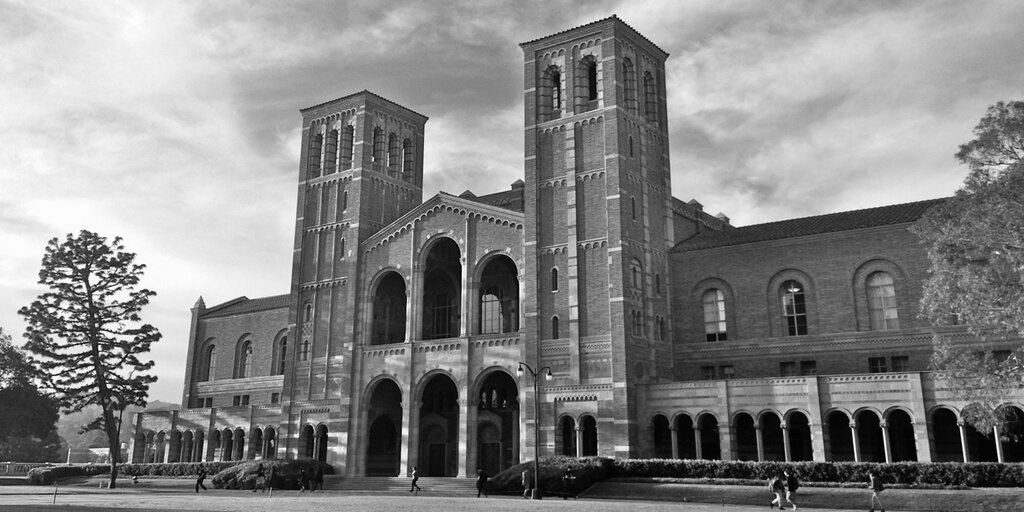

In [59]:
#load image in grayscale and display

image_UCLA_gray = Gray.(image_UCLA)

image_UCLA_gray

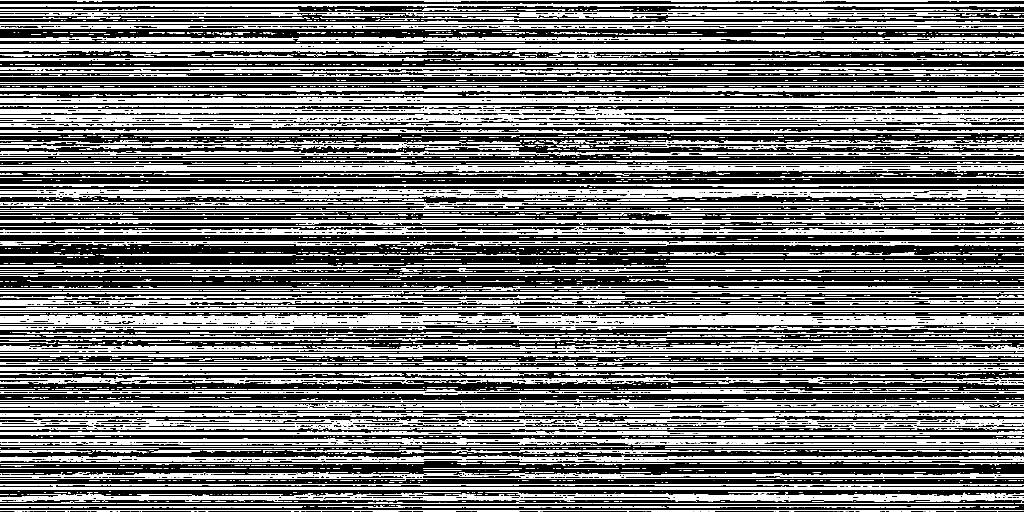

In [60]:
#Let's turn this into a Blurred Grayscale Image so it's safe for Distribution

#turn gray image in to float array

image_float = Float64.(image_UCLA_gray) #C in reference is image_float for us

#define a blur matrix B. Let Y be the blurred image in array form after application of B

B = randn(size(image_float,1), size(image_float,1))
Y = B*image_float

#Let D be the same as blurred image Y but in image form and with values capped between range [0,1]

D = zeros(size(Y,1), size(Y,2))
D = Matrix{RGB{Float32}}(D)

for i=1:size(Y,1)
    for j=1:size(Y,2)
        a = Y[i,j]
        if a < 0
            a = 0.0
        end
        if a > 1
            a = 1.0
        end
    D[i,j]= RGB{Float32}(a,a,a)
    end
end

#Printing the Blurred Grayscale Image with caps
D

In [61]:
image_float[1:10,1:10]

10×10 Matrix{Float64}:
 0.807843  0.807843  0.819608  0.839216  …  0.87451   0.886275  0.894118
 0.807843  0.8       0.807843  0.827451     0.854902  0.870588  0.878431
 0.803922  0.792157  0.792157  0.811765     0.835294  0.847059  0.854902
 0.796078  0.792157  0.792157  0.803922     0.827451  0.827451  0.835294
 0.788235  0.796078  0.803922  0.803922     0.823529  0.811765  0.819608
 0.780392  0.8       0.807843  0.8       …  0.815686  0.8       0.807843
 0.784314  0.796078  0.8       0.792157     0.8       0.792157  0.8
 0.788235  0.792157  0.788235  0.780392     0.784314  0.784314  0.796078
 0.788235  0.792157  0.796078  0.8          0.788235  0.784314  0.788235
 0.788235  0.792157  0.796078  0.803922     0.796078  0.796078  0.796078

In [62]:
B[1:10,1:10]

10×10 Matrix{Float64}:
  0.390547    1.26149     0.991923  …   0.341815   -1.81952   -0.620828
 -2.41852     0.0518125  -0.383006     -1.06073     0.013624   0.061083
  0.305789    0.613525   -0.47808      -0.0309679   1.34101   -1.66704
  0.8542      1.14068    -0.562855     -1.04694     0.270828  -0.907762
  0.0821652   0.175058    2.38205      -0.101824    0.806243   0.309163
 -2.00494     0.923454    2.0762    …   0.430364    1.06899    0.861036
 -0.0602527  -1.89317    -0.792924     -0.776506    0.502576  -0.221821
  0.576413    0.378191    1.51386      -0.834156   -0.329299   0.608222
 -0.199781    0.927064   -1.69763      -0.162886   -1.99285    0.0443115
  0.182246    0.743163   -0.516106     -0.864331    0.130446   0.276325

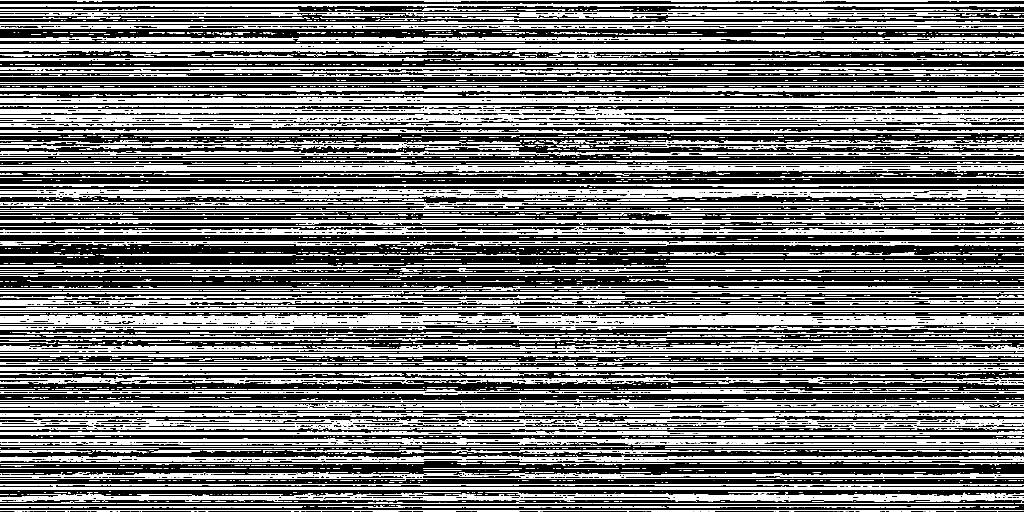

In [63]:
#Let's print Y as an image

Y_image = zeros(size(Y,1), size(Y,2))
#Y_image = Matrix{RGB{Float32}}(Y)

Y_image = Matrix{RGB{Float32}}(Y_image)


for i=1:size(Y,1)
    for j=1:size(Y,2)
        a = Y[i,j]
    Y_image[i,j]= RGB{Float32}(a,a,a)
    end
end

Y_image

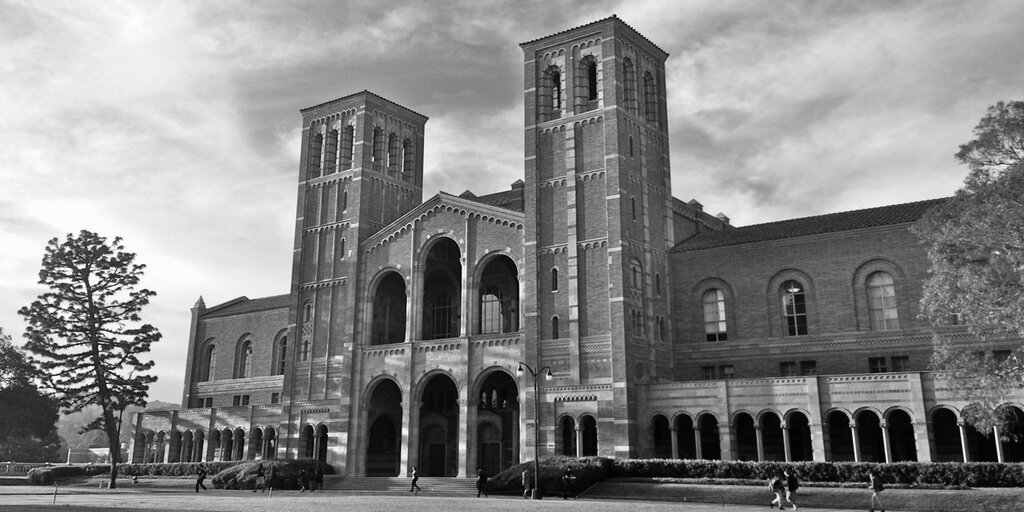

In [64]:
#Let's deblur with the inverse of B.

X = (B^-1)*Y
E = zeros(size(X,1), size(X,2))
E = Matrix{RGB{Float32}}(E)
for i=1:size(Y,1)
    for j=1:size(Y,2)
        a = X[i,j]
        E[i,j]= RGB{Float32}(a,a,a)
    end
end

E

In [65]:
# Now let's use componentwise mutiplication and FFT to achieve the same image blurring
# Let BB be the blur matrix of the same size as image_float

BB = zeros(size(image_float,2), size(image_float,2))
BB[1:size(B,1),1:size(B,2)] = B  #Use the same Gaussian Blur as before for a portion of BB

for i in size(B,1)+1:size(BB,1)
    BB[i,i] = 1
end

# BB = randn(size(image_float,1), size(image_float,2))

fftB = fft(BB) #B_hat
fft_image_float = fft(image_float) #X_hat

fftY = zeros(size(image_float,1), size(image_float,2))
fftY = Matrix{Complex{Float64}}(fftY)


#Element wise multiplication of B_hat with X_hat

for i=1:size(image_float,1)
    for j=1:size(image_float,2)
        fftY[i,j] = fftB[i,j]*fft_image_float[i,j]
    end
end

# FFT Y will hold the blurred image in array format, which is safe for transmission

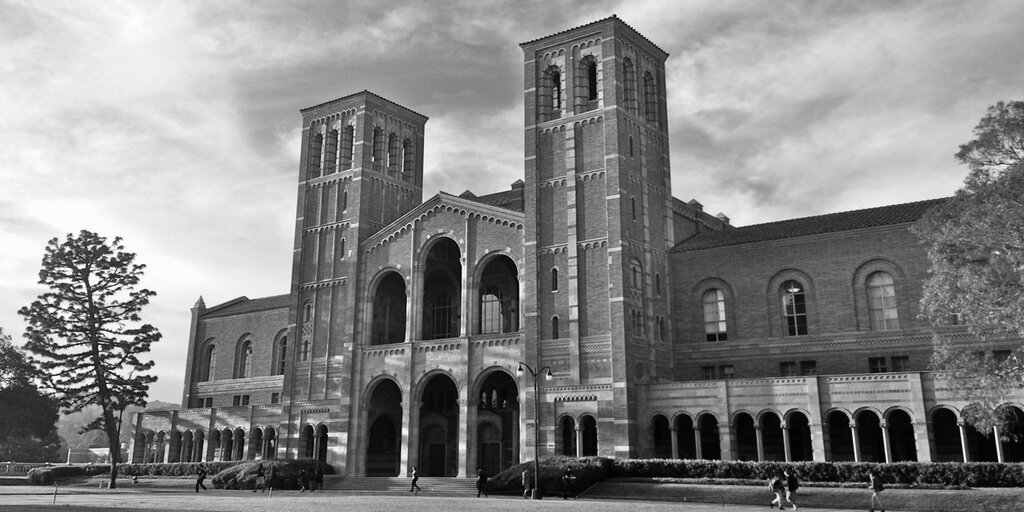

In [66]:
# Upon receiving fftY, we need to do the componentwise division to obtain fftX and then X from fftX

fftX = zeros(size(image_float,1), size(image_float,2))
fftX = Matrix{Complex{Float64}}(fftY) #fftXfftX

for i=1:size(fftX,1)
    for j=1:size(fftX,2)
        fftX[i,j] = fftY[i,j]/fftB[i,j]
    end
end

#From fftX, we obtain X using an inverse DFT             
            
X = ifft(fftX)
deblurred = zeros(size(X,1), size(X,2))
deblurred = Matrix{RGB{Float32}}(deblurred)

for i=1:size(X,1)
    for j=1:size(X,2)
        x = Float32(real(X[i,j]))
        deblurred[i,j] = RGB{Float32}(x,x,x)
    end
end

deblurred

Now let's try to use the QFT-MPO instead of the FFT to blur and deblur

In [103]:
#First we read in each row of image_float as an array and convert into a MPS
#Then we feed the MPS to the DFT-MPO to obtain DFT-MPS
#Then we convert DFT-MPS back to a discrete array of same length as the row
#Do this for all rows and you have the row-wise DFT for image 


cutoff = 1E-15
maxdim = 10

#Row-wise DFT

N = 10
sites = siteinds("Qubit",N)

dft_row = zeros(size(image_float,1), size(image_float,2))
dft_row = Matrix{Complex{Float64}}(dft_row)

for i in 1:size(image_float,1)
    M = MPS(image_float[i,:],sites;cutoff=cutoff,maxdim=maxdim)
    ℱM = apply_dft_mpo(M; cutoff=1e-15)
    dft_row[i,:] = mps_to_discrete_function(ℱM) #Contains row-wise DFT
    if mod(i,100) == 0
        println("Row Iteration ",i)
    end
end

Row Iteration 100
Row Iteration 200
Row Iteration 300
Row Iteration 400
Row Iteration 500


In [98]:
#Col-wise FFT on dft_row

N = 9
sites = siteinds("Qubit",N)

dft_col = zeros(size(image_float,1), size(image_float,2))
dft_col = Matrix{Complex{Float64}}(dft_col)

for i in 1:size(image_float,2)
    M_col = MPS(dft_row[:,i],sites;cutoff=cutoff,maxdim=maxdim)
    ℱM_col = apply_dft_mpo(M_col; cutoff=1e-15)
    dft_col[:,i] = mps_to_discrete_function(ℱM_col) #Contains col-wise DFT
    if mod(i,100) == 0
        println("Col Iteration ",i)
    end
end

Col Iteration 100
Col Iteration 200
Col Iteration 300
Col Iteration 400
Col Iteration 500
Col Iteration 600
Col Iteration 700
Col Iteration 800
Col Iteration 900
Col Iteration 1000


In [101]:
dft_col[1:10,1:10]

10×10 Matrix{ComplexF64}:
    377.402-1.97458e-7im  …   -0.0432242+0.00856639im
   0.241137-0.142998im         0.0358508-0.0149654im
   0.399948-0.128023im       0.000592224+0.0351114im
   0.238812+0.050029im       -0.00667541-0.00192008im
    0.21502-0.482245im         0.0460295-0.0257295im
   0.112442+0.107336im    …  -0.00457642-0.0100583im
   0.257885-0.0350911im       -0.0253348-0.0199715im
 0.00382566-0.031323im        -0.0139007+0.00602381im
   0.474022-0.915852im        0.00252089+0.0386145im
  0.0658597-0.0314124im        0.0108139+0.00741706im

In [102]:
fft_image_float[1:10,1:10]

10×10 Matrix{ComplexF64}:
 2.73272e5+0.0im       26700.1-20017.8im  …  -283.358-8220.23im
  -272.875-50370.4im  -2452.62-3960.08im     -1124.87+2061.16im
  -1379.07-17183.2im  -1158.78-10562.6im     -470.319+683.52im
   10736.8-16993.4im  -2894.45+1812.01im      659.383+820.808im
   6306.25-11709.7im    396.03-3165.4im      -300.204-862.335im
   5077.06+50.7457im  -1374.54+5100.38im  …   623.449+2499.75im
   2206.94-4064.11im  -3092.73-1134.06im     -253.964+181.502im
    1532.6-3351.68im   86.1211-4031.22im     -212.691+83.2579im
   3327.26-3055.54im    3331.5+1235.53im      868.996-1529.39im
   4194.53-1076.72im   -389.65+1868.4im      -82.0193-208.941im

In [ ]:
d = 2
N = 4
A = randn(d^N)
println(A)
println(length(A))
# create an array of siteindices
sites = siteinds(d,N)
println(sites)
println(length(sites))

cutoff = 1E-15
maxdim = 10
M = MPS(A,sites;cutoff=cutoff,maxdim=maxdim)

println("Printing contents of MPS")
for t in M
    println(t)
end

Let's turn to some evaluations of the FFT function

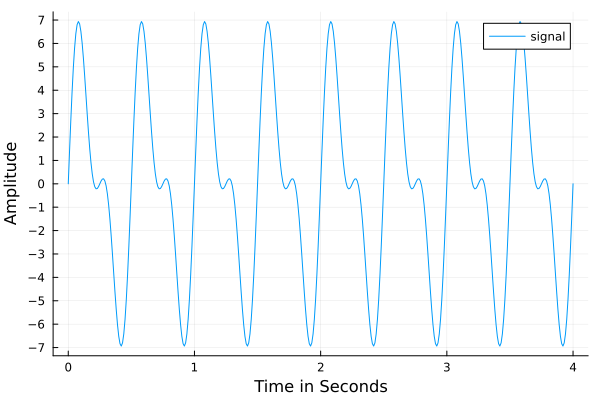

In [10]:
dt = 0.01
t = 0:dt:4
y = 3*sin.(4*2*pi*t) + 5*sin.(2*2*pi*t)
plot(t, y, yticks=-7:1:7, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")

In [11]:
println(typeof(y))
println(size(y))

Vector{Float64}
(401,)


Let's calculate the FFT for this signal using FFTW first and then using DFT-MPO. Next we can compare images

In [12]:
F = fft(y)
F

401-element Vector{ComplexF64}:
 -3.597122599785507e-14 + 0.0im
   0.006418144350064381 - 0.8192097170025776im
   0.026727620357105963 - 1.7056473928809086im
    0.06463648285815843 - 2.749609270996059im
     0.1287560261227318 - 4.10733262546961im
    0.23984139394528153 - 6.119647714375755im
    0.45983305925033097 - 9.775149395220684im
       1.09169272899888 - 19.88662984795837im
     62.795047463550105 - 1000.6005157598265im
    -1.3513113979375322 + 19.133167864918292im
    -0.6409131688171015 + 8.164016735486912im
   -0.33683085290801884 + 3.898851433478498im
   -0.09031602689089219 + 0.9578465599919878im
                        ⋮
   -0.09031602689088819 - 0.9578465599919884im
    -0.3368308529080437 - 3.8988514334784967im
    -0.6409131688170812 - 8.164016735486914im
    -1.3513113979375095 - 19.1331678649183im
     62.795047463550084 + 1000.6005157598265im
     1.0916927289988552 + 19.886629847958375im
    0.45983305925035234 + 9.775149395220684im
    0.23984139394525722 + 6.1

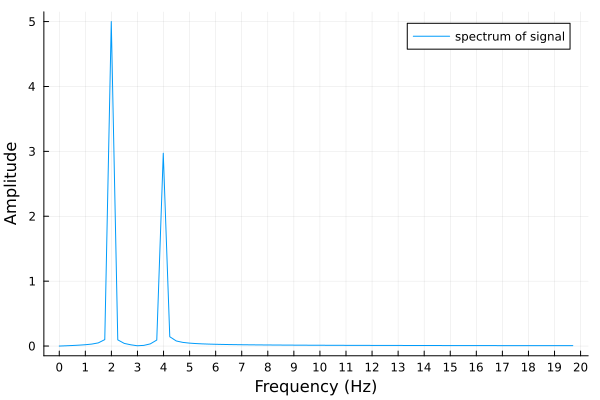

In [13]:
F = fft(y)
n = length(y)/2
amps = abs.(F)/n
freq = [0:79]/(2*n*dt)
plot(freq, amps[1:80], xticks=0:1:20, label="spectrum of signal",
     ylabel="Amplitude", xlabel="Frequency (Hz)")

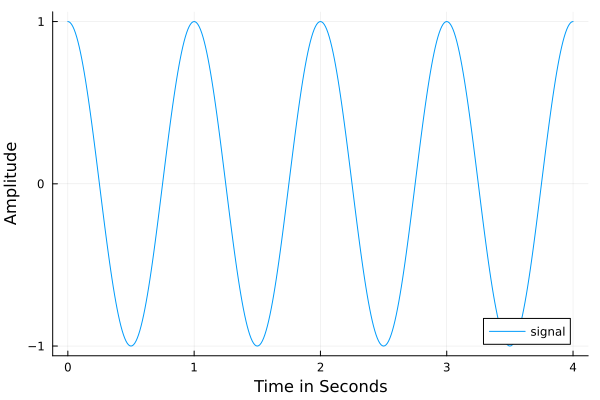

In [14]:
#Let's calculate the FFT for a really simple function y = cos(2*pi*x)

dt = 0.01
t = 0:dt:4
y = cos.(2*1*pi*t)
plot(t, y, yticks=-2:1:2, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")

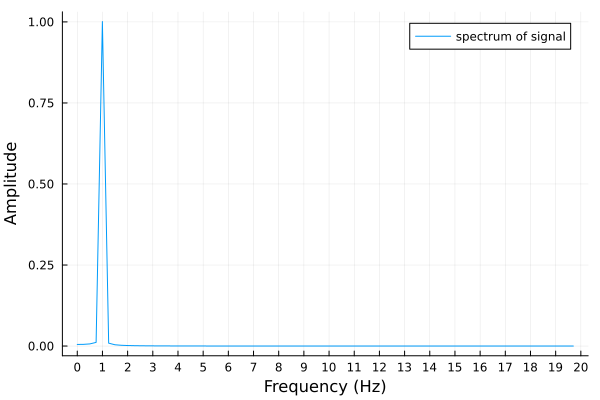

In [15]:
F = fft(y)
n = length(y)/2
amps = abs.(F)/n
freq = [0:79]/(2*n*dt) #Just plot the first 80 points from the DFT matrix
plot(freq, amps[1:80], xticks=0:1:20, label="spectrum of signal", ylabel="Amplitude", xlabel="Frequency (Hz)")

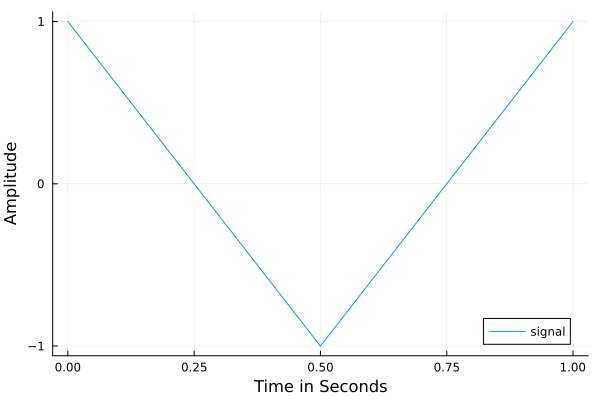

In [16]:
#Let's calculate the FFT for a really simple function y = cos(2*pi*x) using only n = 4 points

dt = 0.25
t = 0:dt:1
y = cos.(2*1*pi*t)
plot(t, y, yticks=-2:1:2, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")

In [17]:
F = fft(y)
n = length(y)/2
amps = abs.(F)/n
freq = [0:3]/(2*n*dt)
plot(freq, amps[1:4], xticks=0:1:20, label="spectrum of signal",
     ylabel="Amplitude", xlabel="Frequency (Hz)")

In [18]:
#Let's calculate the FFT for a really simple function y = cos(2*pi*x) using only n = 8 points

dt = 0.25/2
t = 0:dt:1
y = cos.(2*1*pi*t)
plot(t, y, yticks=-2:1:2, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")

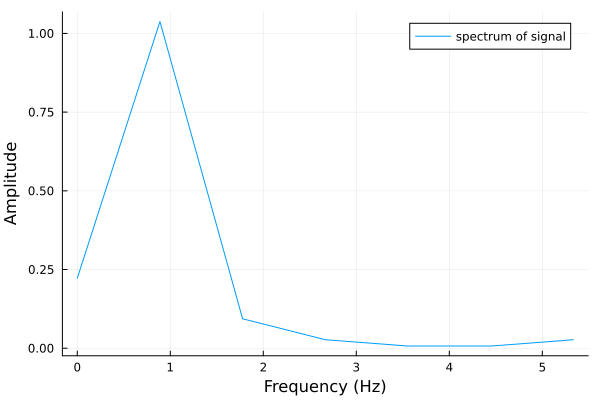

In [19]:
F = fft(y)
n = length(y)/2
amps = abs.(F)/n
freq = [0:6]/(2*n*dt)
plot(freq, amps[1:7], xticks=0:1:20, label="spectrum of signal",
     ylabel="Amplitude", xlabel="Frequency (Hz)")

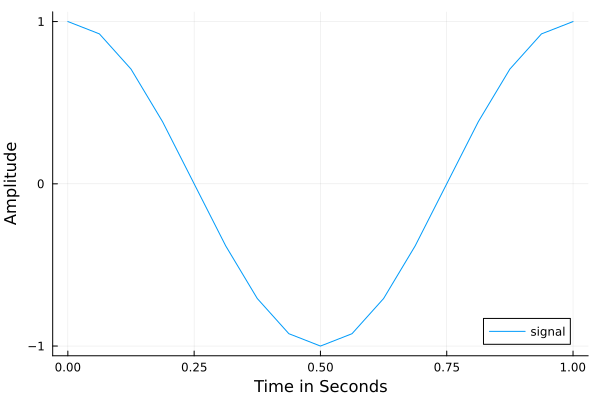

In [20]:
#Let's calculate the FFT for a really simple function y = cos(2*pi*x) using only n = 16 points

dt = 0.25/4
t = 0:dt:1
y = cos.(2*1*pi*t)
plot(t, y, yticks=-2:1:2, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")

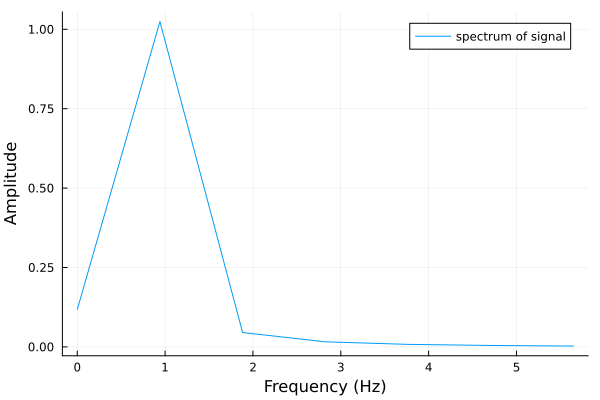

In [21]:
F = fft(y)
n = length(y)/2
amps = abs.(F)/n
freq = [0:6]/(2*n*dt)
plot(freq, amps[1:7], xticks=0:1:20, label="spectrum of signal",
     ylabel="Amplitude", xlabel="Frequency (Hz)")

In [22]:
dt = 0.25
t = 0:dt:0.75
y = cos.(2*1*pi*t)
plot(t, y, yticks=-2:1:2, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")
y

4-element Vector{Float64}:
  1.0
  6.123233995736766e-17
 -1.0
 -1.8369701987210297e-16

In [23]:
#Let's compare FFT values for 1D Image FFT vs 2D Image FFT for cos 2 pi x

dt = 0.25
t = 0:dt:0.75
y = cos.(2*1*pi*t)
plot(t, y, yticks=-2:1:2, label="signal",
     xlabel="Time in Seconds", ylabel="Amplitude")

y_vec = vec(y)
fft_y_vec = fft(y_vec)

println("FFT of 1D Array version of y")
println(size(fft_y_vec))
println(fft_y_vec)

#Create a 2D matrix version of y

println("FFT of 2D Array version of Image")
println(size(fft_image_float))
println(fft_image_float[1:20])

vectorized_fft_image_float_vec = vec(fft_image_float)
println("Printing vector version of FFT of 2D Array version of Image")
println(size(vectorized_fft_image_float_vec))
println(vectorized_fft_image_float_vec[1:20])

Difference = abs.(vectorized_fft_image_float_vec)- abs.(fft_image_float_vec)
println("Printing difference between FFT values for 1D array and 2D array (vectorized)")
println(Difference[1:20])

FFT of 1D Array version of y
(4,)
ComplexF64[-1.224646799147353e-16 + 0.0im, 2.0 - 2.4492935982947064e-16im, 1.224646799147353e-16 + 0.0im, 2.0 + 2.4492935982947064e-16im]
FFT of 2D Array version of Image
(700, 1336)
ComplexF64[487457.0274509803 + 2.084732386720134e-11im, -665.3115413955693 - 89829.18146021577im, -2563.6772996747854 - 30640.892143398465im, 18989.517274882004 - 30410.431460651915im, 11125.1995806827 - 20963.11598169548im, 9043.67544202035 + 17.30977143278136im, 3857.001685435427 - 7285.983957368034im, 2669.0181270884555 - 6024.053158342103im, 5862.880212147015 - 5531.338806751755im, 7455.118325096216 - 2033.1211852006097im, 2820.371772950712 + 3644.3587020870846im, 421.0839677360556 + 479.11436567463363im, 64.25414907838305 + 704.3618537373206im, -1063.385541407972 - 145.0544548271074im, -3419.095570937463 + 226.86211232430708im, -2881.7758222275133 - 2457.2103468688583im, -297.93103425571303 - 2231.9961086124604im, -896.3160010594095 - 1994.130696585438im, -931.0538177

LoadError: UndefVarError: `fft_image_float_vec` not defined

In [24]:
#Let's compare FFT values for 1D Image FFT vs 2D Image FFT

image_float_vec = vec(image_float)
fft_image_float_vec = fft(image_float_vec)

println("FFT of 1D Array version of Image")
println(size(fft_image_float_vec))
println(fft_image_float_vec[1:20])

println("FFT of 2D Array version of Image")
println(size(fft_image_float))
println(fft_image_float[1:20])

vectorized_fft_image_float_vec = vec(fft_image_float)
println("Printing vector version of FFT of 2D Array version of Image")
println(size(vectorized_fft_image_float_vec))
println(vectorized_fft_image_float_vec[1:20])

Difference = abs.(vectorized_fft_image_float_vec)- abs.(fft_image_float_vec)
println("Printing difference between FFT values for 1D array and 2D array (vectorized)")
println(Difference[1:20])

FFT of 1D Array version of Image
(935200,)
ComplexF64[487457.0274509803 + 1.781848973925193e-11im, 47513.034488828685 - 35833.4924000965im, -13843.338718861627 - 26948.72124873228im, -20847.996473222374 - 8860.148266729802im, 7074.387915843967 + 1454.7589235829153im, -1544.4905309734654 - 6837.780212294479im, -142.55436054852052 - 9264.729143303535im, 6737.622262821696 - 8819.698724967204im, -3118.64942530355 - 5474.382111980176im, -875.7981385354353 - 14616.003053458395im, -861.1885911902216 - 474.7673330468753im, -1456.3122123072521 + 140.0469746675707im, 7850.823521480129 - 6335.159480772373im, -1614.967955522582 - 3464.932940952639im, -2002.6605948034212 - 4688.485579112974im, 5098.20052958691 - 2615.3799896767905im, -5877.741566194314 - 6172.365418308549im, -808.9436115606832 + 2033.2200879954867im, 7159.906033387775 - 5680.823818949745im, -5725.790105053278 - 4436.77952450154im]
FFT of 2D Array version of Image
(700, 1336)
ComplexF64[487457.0274509803 + 2.084732386720134e-11im, -

In [56]:
size(fft_image_float)

(700, 1336)

In [54]:
fft_image_float[1:10,1:10]

10×10 Matrix{ComplexF64}:
 487457.0+2.08473e-11im   47602.5-35755.1im  …  -610.608-14651.0im
 -665.312-89829.2im      -4403.33-7050.58im     -1987.89+3689.02im
 -2563.68-30640.9im      -2110.77-18832.3im     -811.862+1228.75im
  18989.5-30410.4im       -5146.7+3273.42im      1193.87+1453.82im
  11125.2-20963.1im       676.726-5655.27im     -548.985-1529.02im
  9043.68+17.3098im      -2371.31+9124.47im  …   1176.76+4442.16im
   3857.0-7285.98im      -5534.82-1955.91im      -439.94+342.095im
  2669.02-6024.05im       68.4617-7193.02im     -379.024+167.518im
  5862.88-5531.34im       5967.65+2126.41im      1496.73-2756.17im
  7455.12-2033.12im      -641.369+3352.12im     -148.393-365.989im

Lets take an array of size 2^n and write it an an ITensor first, and then as an MPS

In [26]:
d = 2
N = 4
A = randn(d^N)
println(A)
println(length(A))
# create an array of siteindices
sites = siteinds(d,N)
println(sites)
println(length(sites))

[0.06368369496881034, -1.1743983953257897, -0.6990869360972417, 0.16329491631053283, 1.8998355602115986, -0.5956805900066935, -0.9606792274652177, 1.2408425184418934, -0.8221922694749125, -0.7022358348483732, -1.296790435125284, -0.16465266080594457, -0.5288962438433316, 0.4950391621360167, 0.22661798585986864, -0.3249359828915587]
16
Index{Int64}[(dim=2|id=728|"Site,n=1"), (dim=2|id=353|"Site,n=2"), (dim=2|id=492|"Site,n=3"), (dim=2|id=238|"Site,n=4")]
4


In [27]:
cutoff = 1E-15
maxdim = 10
M = MPS(A,sites;cutoff=cutoff,maxdim=maxdim)

println("Printing contents of MPS")
for t in M
    println(t)
end

Printing contents of MPS
ITensor ord=2
Dim 1: (dim=2|id=728|"Site,n=1")
Dim 2: (dim=2|id=808|"Link,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 -0.9089733970814543  0.4168541272414136
  0.4168541272414136  0.9089733970814545
ITensor ord=3
Dim 1: (dim=2|id=808|"Link,n=1")
Dim 2: (dim=2|id=353|"Site,n=2")
Dim 3: (dim=4|id=20|"Link,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×4
[:, :, 1] =
 -0.7561260589815476   0.6101486596479739
 -0.10567019425166124  0.21172105730330532

[:, :, 2] =
  0.33987950097073205   0.44888841565148996
 -0.7047902698183315   -0.4315689871656501

[:, :, 3] =
 -0.37555511900440003  -0.6289127701567037
 -0.6665071576477086    0.1385470639450176

[:, :, 4] =
  0.414383470155977    0.17517571451972808
 -0.21879829620130176  0.8658678388087877
ITensor ord=3
Dim 1: (dim=4|id=20|"Link,n=2")
Dim 2: (dim=2|id=492|"Site,n=3")
Dim 3: (dim=2|id=635|"Link,n=3")
NDTensors.Dense{Float64, Vector{Float64}}
 4×2×2
[:, :, 1] =
 -0.31341037528084875     -0.869160415

Let's load a sample image in

**Generating DFT vectors of different sizes for Cos(2πx) using both QFT-MPO and Classical FFT**

In [28]:
n = 5
s = siteinds("Qubit", n)
 
f(x) = cos(2*π*x)

ψ = @time function_to_mps(f, s, 0.0, 1.0; cutoff=1e-15)

#Display the 2^n vector form of the input function

display(lineplot(mps_to_discrete_function(ψ); title="ψ"))

  6.583176 seconds (8.30 M allocations: 573.645 MiB, 2.90% gc time, 99.92% compilation time)


      ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ψ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
      ┌────────────────────────────────────────┐ 
    1 │⠀⠉⠑⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠔⠁⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠈⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠸⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠤⠤⠤⠤⠤⠤⠤⠤⠼⡦⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⢤⠧⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡄⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⡀⠀⠀⠀⠀⠀⠀⢀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⡄⠀⠀⠀⠀⢀⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -1 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⣀⣀⡠⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      └────────────────────────────────────────┘ 
      ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

In [29]:
for t in ψ
    println(t)
end

ITensor ord=2
Dim 1: (dim=2|id=253|"Qubit,Site,n=1")
Dim 2: (dim=1|id=667|"Link,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×1
 -0.7071067811865472
  0.7071067811865475
ITensor ord=3
Dim 1: (dim=1|id=667|"Link,n=1")
Dim 2: (dim=2|id=448|"Qubit,Site,n=2")
Dim 3: (dim=2|id=628|"Link,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 1×2×2
[:, :, 1] =
 -0.7730104533627367  0.6343932841636453

[:, :, 2] =
 0.6343932841636454  0.7730104533627369
ITensor ord=3
Dim 1: (dim=2|id=628|"Link,n=2")
Dim 2: (dim=2|id=886|"Qubit,Site,n=3")
Dim 3: (dim=2|id=966|"Link,n=3")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×2
[:, :, 1] =
 -0.6532814824381884   -0.6532814824381884
  0.27059805007309856  -0.2705980500730984

[:, :, 2] =
 -0.2705980500730987   0.2705980500730982
 -0.6532814824381886  -0.6532814824381885
ITensor ord=3
Dim 1: (dim=2|id=966|"Link,n=3")
Dim 2: (dim=2|id=897|"Qubit,Site,n=4")
Dim 3: (dim=2|id=874|"Link,n=4")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×2
[:, :, 1] =
 -0.6935

In [30]:
ℱψ = @time apply_dft_mpo(ψ; cutoff=1e-15)
display(lineplot(real(mps_to_discrete_function(ℱψ)); title="real(ℱψ)"))
display(lineplot(imag(mps_to_discrete_function(ℱψ)); title="imag(ℱψ)"))

 67.545245 seconds (91.27 M allocations: 6.208 GiB, 4.02% gc time, 99.78% compilation time)


      ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀real(ℱψ)⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
      ┌────────────────────────────────────────┐ 
    3 │⠀⢀⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠒⠓⠚⠚⠛⠚⠛⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠚⠛⠚⠛⠒⠓⠒⠒⠓⠒⠒⠒⠒⠒⠒⠒⠒│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -1 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      └────────────────────────────────────────┘ 
      ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

          ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀imag(ℱψ)⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
          ┌────────────────────────────────────────┐ 
    4e⁻¹⁵ │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢠⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⡎⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⡆⠀⠀⠀⠀⠀⠀⠀⠀⡸⡇⠀⠀⢰⡆⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠤⡧⠼⡤⢤⢤⣤⡤⢤⡤⢤⠤⠤⠤⠤⠧⠼⡤⢤⠤⠤⠤⠤⡤⢤⠧⠼⡤⢤⠧⠼⡧⠤⠤⠤⠤⠤⠤⠤⠤│ 
          │⠀⠀⠀⢱⡜⠀⠀⡇⢸⠘⠎⠀⠀⠀⠀⠀⠀⢇⡸⠀⠀⠀⠀⡇⡸⠀⠀⢣⡸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⠀⠀⠁⠀⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠸⡇⠀⠀⠀⠀⢸⡇⠀⠀⠘⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⠀⠀⠀⠀⠀⢇⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -3e⁻¹⁵ │⠀⠀⠀⠀⠀⠀⠀⠸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          └────────────────────────────────────────┘ 
          ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [31]:
fft_output = @time fft(mps_to_discrete_function(ψ))
    
display(lineplot(real(fft_output); title="real(FFT)"))
display(lineplot(imag(fft_output); title="imag(FFT)"))

  0.000322 seconds (277 allocations: 62.484 KiB)


       ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀real(FFT)⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
       ┌────────────────────────────────────────┐ 
    20 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⢰⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⡎⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -10 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       └────────────────────────────────────────┘ 
       ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

          ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀imag(FFT)⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
          ┌────────────────────────────────────────┐ 
    2e⁻¹⁵ │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⠀⠀⢠⡆⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⢰⡇⢸⡇⠀⢠⠎⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⢸⢇⡜⡇⢠⠇⠀⠸⡀⠀⠀⠀⠀⢠⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⢸⢸⡇⢇⢸⠀⠀⠀⠑⡆⠀⠀⠀⡸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⠀⢸⠈⠃⢸⡸⠀⠀⠀⠀⢇⠀⠀⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠤⡤⢼⠤⠤⢼⡧⠤⠤⠤⠤⢼⡴⠶⠮⠥⠼⡤⢤⣤⠤⠮⡧⠤⠤⠤⠤⢼⡧⠤⠤⡧⠤⠤⠤⠤⠤⠤⠤⠤│ 
          │⠀⡇⢸⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⢸⠀⠀⠀⢣⠀⠀⠀⠀⡎⡇⢀⡄⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⡇⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠸⡄⠀⠀⠀⡇⢣⢸⡇⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⡇⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠃⠀⠀⠀⠀⠈⡇⠀⡰⠃⢸⡸⢱⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢱⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡠⠃⠀⢸⡇⠸⡇⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -2e⁻¹⁵ │⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
          └────────────────────────────────────────┘ 
          ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [32]:
@show norm(fft(mps_to_discrete_function(ψ)) / 2^(n/2) - mps_to_discrete_function(ℱψ))

norm(fft(mps_to_discrete_function(ψ)) / 2 ^ (n / 2) - mps_to_discrete_function(ℱψ)) = 7.555265475109678e-15


7.555265475109678e-15

In [33]:
for t in ℱψ
    println(t)
end

ITensor ord=2
Dim 1: (dim=2|id=253|"Qubit,Site,n=1")
Dim 2: (dim=2|id=302|"Link,n=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
   0.8979858443741195 - 0.42093086455036854im  -0.1160918085459344 + 0.05441803525590675im
 -0.12821322308006688 + 0.0im                  -0.9917466256193772 + 0.0im
ITensor ord=3
Dim 1: (dim=2|id=448|"Qubit,Site,n=2")
Dim 2: (dim=2|id=302|"Link,n=4")
Dim 3: (dim=2|id=953|"Link,n=3")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2
[:, :, 1] =
 -0.09735363090719473 - 0.9565556259500505im     0.012585898932969384 + 0.12366372286049601im
 -0.03142466179468788 + 3.469446951953614e-16im   -0.2430740102107053 - 0.0im

[:, :, 2] =
 -0.024611765376434183 - 0.24182480320465363im   0.0031818144706391577 + 0.0312631640366887im
   0.12430253900732927 + 9.71445146547012e-17im     0.9614969552668936 + 0.0im
ITensor ord=3
Dim 1: (dim=2|id=886|"Qubit,Site,n=3")
Dim 2: (dim=2|id=953|"Link,n=3")
Dim 3: (dim=2|id=72|"Link,n=2")
NDTensors.Dense{ComplexF64, Vecto

**Repeat with a much lower cutoff value**

In [34]:
n = 5
s = siteinds("Qubit", n)
 
f(x) = cos(2*π*x)

ψ = @time function_to_mps(f, s, 0.0, 1.0; cutoff=1e-2)

#Display the 2^n vector form of the input function

display(lineplot(mps_to_discrete_function(ψ); title="ψ"))

  7.761996 seconds (7.31 M allocations: 516.958 MiB, 2.35% gc time, 99.82% compilation time: <1% of which was recompilation)


      ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ψ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
      ┌────────────────────────────────────────┐ 
    1 │⠀⠉⢣⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠒⠂⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠤⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠸⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠘⠒⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠤⠤⠤⠤⠤⠤⠤⠤⢼⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⢼⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠤⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⢰⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠒⡆⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -1 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⠤⢄⣀⡜⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      └────────────────────────────────────────┘ 
      ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

In [35]:
n = 5
s = siteinds("Qubit", n)
 
f(x) = cos(2*π*x)

ψ = @time function_to_mps(f, s, 0.0, 1.0; cutoff=1e-4)

#Display the 2^n vector form of the input function

display(lineplot(mps_to_discrete_function(ψ); title="ψ"))

  0.032551 seconds (50.30 k allocations: 3.830 MiB, 95.45% compilation time: 100% of which was recompilation)


      ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ψ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
      ┌────────────────────────────────────────┐ 
    1 │⠀⠉⠑⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠔⠁⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠈⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠸⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠤⠤⠤⠤⠤⠤⠤⠤⠼⡤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⢤⠧⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤⠤│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⢱⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡄⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⡀⠀⠀⠀⠀⠀⠀⢀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⡄⠀⠀⠀⠀⢀⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -1 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⣀⣀⡠⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      └────────────────────────────────────────┘ 
      ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

**Let's take an example of functions with cusps**

In [36]:
n = 5
s = siteinds("Qubit", n)
 
f1(x) = cos(2*π*x) + 2*exp(-3*abs(x-0.2))
f2(x) = cos(2*π*x) + 2*exp(-3*abs(x-0.2)) + exp(-2*abs(x-0.4)) + 2*exp(-2*abs(x-0.7)) + exp(-2*abs(x-0.8)) + 2*exp(-2*abs(x-0.9))
f3(x) = abs(x-0.4)


ψ1 = @time function_to_mps(f1, s, 0.0, 1.0; cutoff=1e-15)

ψ2 = @time function_to_mps(f2, s, 0.0, 1.0; cutoff=1e-15)

ψ3 = @time function_to_mps(f3, s, 0.0, 1.0; cutoff=1e-15)


#Display the 2^n vector form of the input function

display(lineplot(mps_to_discrete_function(ψ1); title="ψ1"))
display(lineplot(mps_to_discrete_function(ψ2); title="ψ2"))
display(lineplot(mps_to_discrete_function(ψ3); title="ψ3"))

  0.284794 seconds (158.17 k allocations: 11.388 MiB, 98.82% compilation time)
  0.058325 seconds (84.99 k allocations: 6.115 MiB, 95.74% compilation time)
  0.059658 seconds (75.40 k allocations: 5.490 MiB, 95.35% compilation time)


      ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ψ1⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
      ┌────────────────────────────────────────┐ 
    3 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⢀⡠⠤⠤⠤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠊⠁⠀⠀⠀⠀⠘⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠔⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠎⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡔⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⡔⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠳⢖⡒⠒⠒⢒⡲⠚⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒⠒│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   -1 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
      └────────────────────────────────────────┘ 
      ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

     ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ψ2⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
     ┌────────────────────────────────────────┐ 
   6 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠤⠒⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠎⠁⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠎⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⢀⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⡠⠃⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⢀⠎⠁⠀⠀⠈⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⢣⡀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⡰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠢⣀⣀⡠⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   3 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     └────────────────────────────────────────┘ 
     ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

       ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ψ3⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
       ┌────────────────────────────────────────┐ 
   0.6 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠎⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡜⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⢣⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠱⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠘⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡜⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠈⢣⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠱⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠘⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡜⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠈⢆⠀⠀⠀⠀⠀⠀⠀⢀⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢣⡀⠀⠀⠀⠀⢠⠎⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⡄⠀⠀⡰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
     0 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠢⡜⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
       └────────────────────────────────────────┘ 
       ⠀0⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀40⠀ 

In [37]:
for t in ψ1
    println(t)
end

ITensor ord=2
Dim 1: (dim=2|id=770|"Qubit,Site,n=1")
Dim 2: (dim=2|id=95|"Link,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 -0.9991045635505188   -0.04230923176479971
 -0.04230923176479971   0.9991045635505188
ITensor ord=3
Dim 1: (dim=2|id=95|"Link,n=1")
Dim 2: (dim=2|id=685|"Qubit,Site,n=2")
Dim 3: (dim=4|id=409|"Link,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×4
[:, :, 1] =
 -0.8923358473347793   -0.29929173660581
 -0.07939412416436575   0.3284170595583819

[:, :, 2] =
  0.12985894068857212  -0.8533238147984742
 -0.18548229705449085  -0.4696503381244511

[:, :, 3] =
 0.04034899189398576  -0.25991679094676323
 0.9590979222187046    0.10462502679970165

[:, :, 4] =
  0.43040138236035314  -0.3386830159325893
 -0.19855494484732855   0.812788040424917
ITensor ord=3
Dim 1: (dim=4|id=409|"Link,n=2")
Dim 2: (dim=2|id=503|"Qubit,Site,n=3")
Dim 3: (dim=4|id=599|"Link,n=3")
NDTensors.Dense{Float64, Vector{Float64}}
 4×2×4
[:, :, 1] =
 -0.7021024540196192     -0.67391140996972

In [38]:
for t in ψ2
    println(t)
end

ITensor ord=2
Dim 1: (dim=2|id=770|"Qubit,Site,n=1")
Dim 2: (dim=2|id=60|"Link,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 -0.632992830106039   -0.7741576564462482
 -0.7741576564462482   0.632992830106039
ITensor ord=3
Dim 1: (dim=2|id=60|"Link,n=1")
Dim 2: (dim=2|id=685|"Qubit,Site,n=2")
Dim 3: (dim=4|id=443|"Link,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×4
[:, :, 1] =
 -0.6609603714822846   -0.7448686852363758
 -0.06812253737087924   0.06050908185047432

[:, :, 2] =
  0.6873903542486216   -0.6128724245674118
 -0.24050587065686754  -0.30665749341961157

[:, :, 3] =
 -0.17870327442592734   0.045347388463301594
  0.47254113471185616  -0.8618083488074602

[:, :, 4] =
 0.24226231222665992  -0.25981079138221663
 0.845116040604464     0.3994824184729188
ITensor ord=3
Dim 1: (dim=4|id=443|"Link,n=2")
Dim 2: (dim=2|id=503|"Qubit,Site,n=3")
Dim 3: (dim=4|id=783|"Link,n=3")
NDTensors.Dense{Float64, Vector{Float64}}
 4×2×4
[:, :, 1] =
 -0.6830180020859586     -0.728206444016

Max bond dimension is 4

In [39]:
for t in ψ3
    println(t)
end

ITensor ord=2
Dim 1: (dim=2|id=770|"Qubit,Site,n=1")
Dim 2: (dim=2|id=285|"Link,n=1")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2
 -0.3840158048743706  -0.9233265194971327
 -0.923326519497133    0.3840158048743707
ITensor ord=3
Dim 1: (dim=2|id=285|"Link,n=1")
Dim 2: (dim=2|id=685|"Qubit,Site,n=2")
Dim 3: (dim=3|id=873|"Link,n=2")
NDTensors.Dense{Float64, Vector{Float64}}
 2×2×3
[:, :, 1] =
 -0.5219008984683867   -0.7707497711688629
 -0.30672624111527397   0.19870393914648746

[:, :, 2] =
  0.12973003812240652   0.15080454921912284
 -0.8796102882752691   -0.4321039758019769

[:, :, 3] =
 0.015508567402574249  -0.37366060307495186
 0.35842445955828545   -0.8553766099427398
ITensor ord=3
Dim 1: (dim=3|id=873|"Link,n=2")
Dim 2: (dim=2|id=503|"Qubit,Site,n=3")
Dim 3: (dim=3|id=823|"Link,n=3")
NDTensors.Dense{Float64, Vector{Float64}}
 3×2×3
[:, :, 1] =
 -0.6493137975964703     -0.739184837091912
 -0.1346429224494454      0.11774002386862656
 -0.0016811370059926362   0.001764328855024685

Max bond dimension is 3